# Cassini Cosmic Dust Analyzer - Project 1: Calibrating CDA

## Part 3: First Deep Learning based approach

Last time we took a look at the already existing calibration functions to determine the velocity of impacting dust particles. Especially we focused on functions that considered impacts on the large target (IID) with values derived from QI signals (the grid / channel that is mounted "in front" of the multiplier).

In this notebook we do the next step by creating a simple Keras-based neural network to create a 2 dimensional calibration function. Again we conduct our calibration work only on IID/QI data. The results will be improved and compared next time. Let's set the foundation for a Machine Learning based calibration work!

## Read in the data

In [1]:
# Import default libraries
import pathlib
import zipfile

# Import installed libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import tensorflow as tf

# Matplotlib darkmode
#plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})

In [2]:
# Read in the level 1 data
cal_df = pd.read_pickle("data/level1/CDA__CAT_IID_cal_data.pkl")

In [3]:
# In our example we'll only consider IID QI data
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

In [4]:
iid_qi_cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS
829,4.09,31.3600,0,2000000.0,43.9482,57.00,206.00900,14.83,176.9120,46.67,IID,7.498760e-15
830,4.07,31.9200,0,2000000.0,42.6352,54.00,166.73900,16.33,204.9460,43.67,IID,7.707864e-15
831,4.10,30.6600,0,2000000.0,48.6620,59.16,187.83500,21.34,189.8550,44.34,IID,7.295657e-15
832,4.11,33.3200,0,2000000.0,51.0875,59.50,174.90200,18.50,211.9450,44.00,IID,7.890079e-15
833,4.07,74.9000,0,2000000.0,130.3050,55.67,415.97200,12.83,428.5020,39.33,IID,1.808644e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
3741,7.93,4.5087,0,2000000.0,12.9795,32.17,7.54071,18.67,48.9116,32.33,IID,2.867906e-16
3742,8.23,4.9609,0,2000000.0,16.3490,28.84,37.73430,18.66,52.7411,25.67,IID,2.929684e-16
3743,8.21,3.9368,0,2000000.0,13.3384,37.50,18.02220,18.67,42.9590,40.67,IID,2.336238e-16
3744,7.84,4.2826,0,2000000.0,14.6953,19.33,14.16240,32.33,55.5990,19.67,IID,2.786990e-16


## Plotting the calibration data in 3D

In [5]:
# We want to interacte with the plot. But please note: we use matplotlib for this 3D interaction
# only once. There are more powerful 3D libraries libraries like e.g. plotly
!pip install ipympl
%matplotlib widget

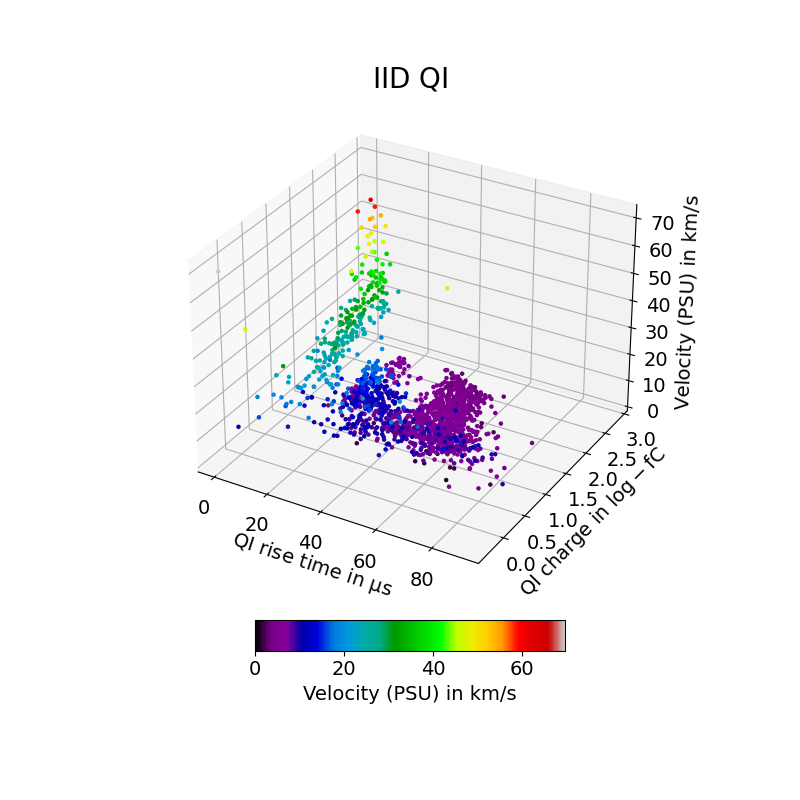

In [6]:
# We will consider the velocity of the PSU vs. the amplitude of the signals and the rise time. Will
# we see a "trend" in the data?

# Channel QI (you can replace it easily with other columns to get a "feeling" for other IID results
ch = "QI"

# 3D Plot
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with log10 charges
sc = ax.scatter(iid_qi_cal_df[ch + '_TR'],
                np.log10(iid_qi_cal_df[ch + '_CHARGE'].values),
                iid_qi_cal_df['PSU_VEL'],
                c=iid_qi_cal_df['PSU_VEL'],
                cmap="nipy_spectral",
                vmin=0,
                vmax=np.max(iid_qi_cal_df['PSU_VEL']),
                marker='.',
                alpha=1,
                zorder=0)

# Some titles and labels
ax.set_title(r'$\mathrm{IID\ ' + ch + '}$', fontsize=20)

ax.set_xlabel(r'$\mathrm{' + ch + '\ rise\ time\ in\ \mu s}$', fontsize=14)
ax.set_ylabel(r'$\mathrm{' + ch + '\ charge\ in\ log-fC}$', fontsize=14)
ax.set_zlabel(r'$\mathrm{Velocity\ (PSU)\ in\ km/s}$', fontsize=14)

ax.set_zlim(0, 1.05 * np.max(iid_qi_cal_df['PSU_VEL']))
ax.tick_params(labelsize=14)

# Create a colorbar
cbar = fig.colorbar(sc,
                    shrink=0.5,
                    aspect=10,
                    orientation='horizontal',
                    pad=0.04)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(label=r'Velocity (PSU) in km/s',
               size=14)

# If you do not run the 3D plot interactively, you can un-comment the following line to 
#ax.view_init(90, 90)

plt.show()

## Data preparation

In [7]:
# Adding the LOG10 scaled data of the QI channel
iid_qi_cal_df.loc[:, "QI_LOG10_CHARGE"] = np.log10(iid_qi_cal_df["QI_CHARGE"])

In [8]:
# Considering only "relevant" data: rise time, log10 charge and the velocity
iid_qi_vel = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL"]].values

# Additionally, shuffle the data to be REALLY sure that there is no "order bias"
np.random.shuffle(iid_qi_vel)

In [9]:
# Split the data in training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iid_qi_vel[:, :2],
                                                                            iid_qi_vel[:, -1],
                                                                            test_size=0.2)

In [10]:
# For our neural network we need a proper data shape
print(f"Before reshaping: {y_train.shape}")

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"After reshaping: {y_train.shape}")

Before reshaping: (1307,)
After reshaping: (1307, 1)


In [11]:
# We scale the data now by applying a StandardScaler that substracts the mean and divides by the
# standard deviation
X_scaler = sklearn.preprocessing.StandardScaler()
y_scaler = sklearn.preprocessing.StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [12]:
# Resulting mean and std of the data
print(f"Mean of the training features: {X_train_scaled.mean(axis=0)}")
print(f"Standard Deviation of the training features: {X_train_scaled.std(axis=0)}")

Mean of the training features: [-3.22975515e-15 -2.87927465e-15]
Standard Deviation of the training features: [1. 1.]


## Machine Learning Training

2023-04-05 23:11:04.558249: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


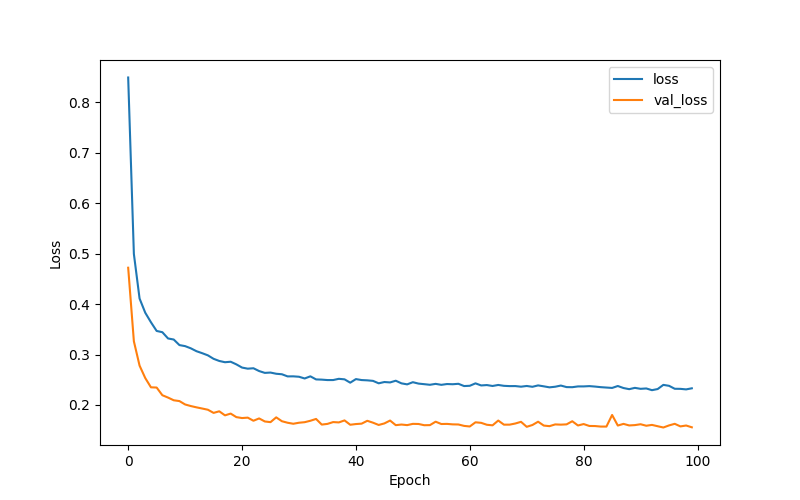

In [13]:
# We create a simple neural network with only 2 hidden layer in this first regression tutorial

# Input shape is 2: rise time and charge
inputs = tf.keras.Input(shape=(2,),
                        name="iid_qi_data",)

# 2 Hidden Layers
layer = tf.keras.layers.Dense(units=64, activation="relu",)(inputs)
layer = tf.keras.layers.Dense(units=32, activation="relu",)(layer)

# Output Layers has only 1 unit, since we map our results to the velocity values
output = tf.keras.layers.Dense(units=1, name="psu_vel",)(layer)

# There are miscellaneous keras APIs to create a model, like Sequential(). I'd recommend to work
# directly with Model(). In this case Sequential() would be good enough, but we'll use Model() in
# more cases later
model = tf.keras.Model(inputs=inputs, outputs=output)

# There are a lot of different losses and metrics to start with. In our first approach we use the
# most common "default" ones. As a loss we start with the MSE. We use the same metrics as last time
model.compile(optimizer="adam",
              loss=["mean_squared_error"],
              metrics=[tf.keras.metrics.RootMeanSquaredError(),
                       "mean_absolute_error"])

# Training the data. Note: we did an 80/20 split of the data. Applying a validation split of 0.25
# on our training data we get a training, validation, testing split of 60/20/20. We "mute" the
# training, since we want to plot the results directly afterwards
model.fit(x=X_train_scaled,
          y=y_train_scaled,
          batch_size=32,
          epochs=100,
          validation_split=0.25,
          verbose=0)

plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'], label="loss")
plt.plot(model.history.history['val_loss'], label="val_loss")
plt.xlabel(r"Epoch")
plt.ylabel(r"Loss")
plt.legend()

In [14]:
# Yes we already trained the model, but let's take a look at the network
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 iid_qi_data (InputLayer)    [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 psu_vel (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Let's evaluate our model on test data
model.evaluate(X_test_scaled, y_test_scaled)

11/11 [==============================] - 0s 3ms/step - loss: 0.2684 - root_mean_squared_error: 0.5181 - mean_absolute_error: 0.3118


[0.2683996260166168, 0.5180730223655701, 0.3118297755718231]

In [16]:
# Ok... we need the "correct" scale
_, rmse_scaled, mae_scaled = model.evaluate(X_test_scaled, y_test_scaled)

rmse = y_scaler.inverse_transform([[rmse_scaled]])
mae = y_scaler.inverse_transform([[mae_scaled]])

print(f"RMSE on test data in km/s: {rmse[0][0]}")
print(f"MAE on test data in km/s: {mae[0][0]}")

11/11 [==============================] - 0s 3ms/step - loss: 0.2684 - root_mean_squared_error: 0.5181 - mean_absolute_error: 0.3118
RMSE on test data in km/s: 14.838076475425105
MAE on test data in km/s: 12.925982212435658


## Solution space in 3D

In [17]:
# We want to plot the resulting solution "hyperplance" in our 3D scatter plot! For this, we need
# to rescale our data and create a 3D mesh

# We define first some self-set limits
min_rt, min_log10ampl = X_scaler.transform([[1, 0.5]])[0]
max_rt, max_log10ampl = X_scaler.transform([[60, 2.5]])[0]

rise_time_range_scaled = np.linspace(min_rt,
                                     max_rt,
                                     100)
log_fc_range_scaled = np.linspace(min_log10ampl,
                                  max_log10ampl,
                                  100)

rise_time_range_scaled, log_fc_range_scaled = np.meshgrid(rise_time_range_scaled,
                                                          log_fc_range_scaled)

In [18]:
# In this section we iterate through the scaled mesh array and re-scale and re-shape them
# accordingly
rise_time_range = []
log_fc_range = []
pred_vel = []

for rt_, fc_ in zip(rise_time_range_scaled, log_fc_range_scaled):

    # First we need to stack the mesh grid "rows" in a way that scaler "understands"
    # We have rows of 2 features: rise time & charge
    stacked_scaled = np.hstack([rt_.reshape(-1, 1),
                                fc_.reshape(-1, 1)])

    rise_time_range.append(X_scaler.inverse_transform(stacked_scaled)[:,0])
    log_fc_range.append(X_scaler.inverse_transform(stacked_scaled)[:,1])
    
    # The same applies to the velocity values after predicting them with the row mesh
    temp_results = model.predict(x=stacked_scaled)
    pred_vel.append(y_scaler.inverse_transform(temp_results.reshape(1,-1))[0])

pred_vel = np.array(pred_vel)

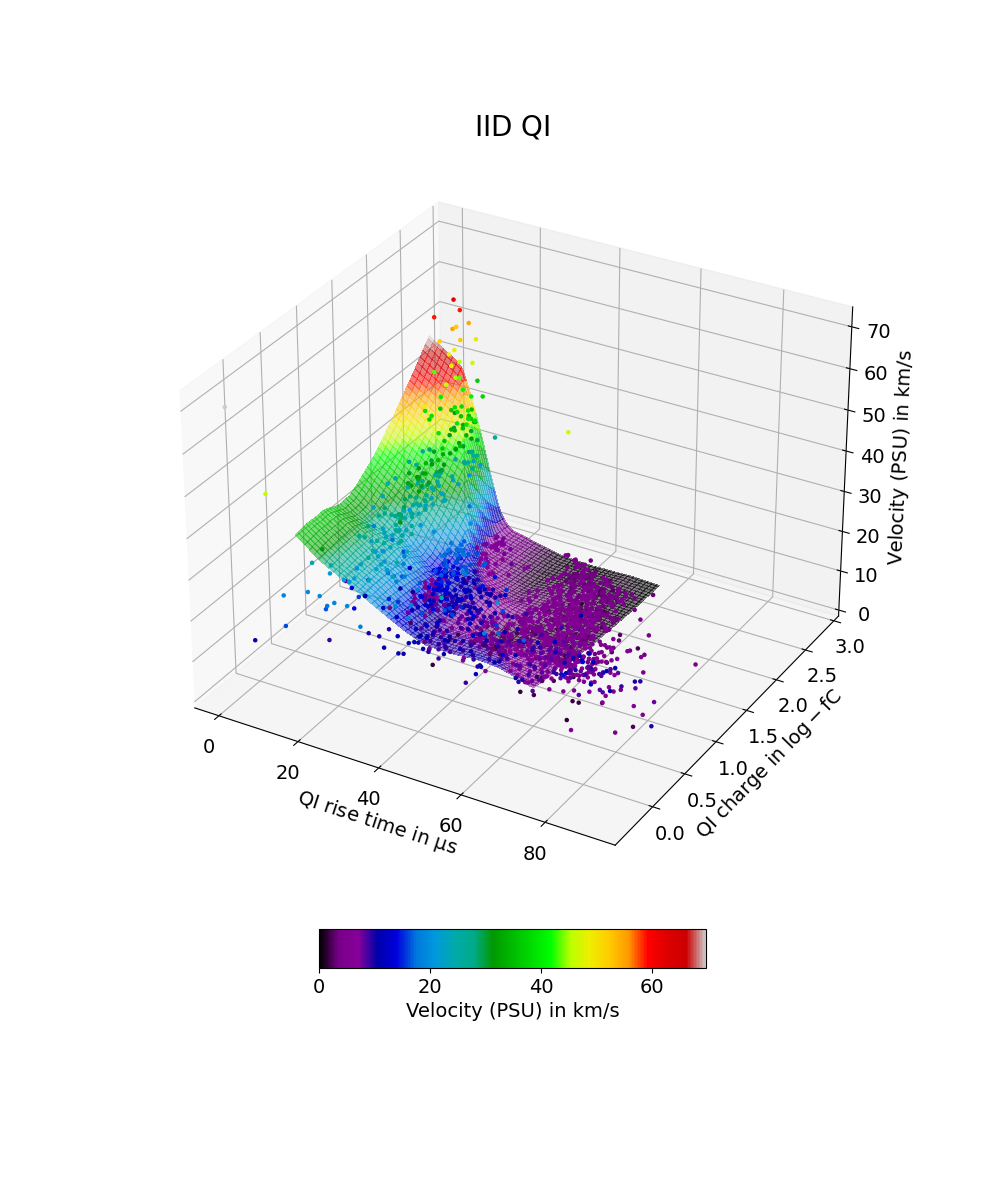

In [19]:
# Now we plot the 3D scatter + the resulting solution space
# Channel QI (you can replace it easily with other columns to get a "feeling" for other IID results
ch = "QI"

# 3D Plot
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with log10 charges
sc = ax.scatter(iid_qi_cal_df[ch + '_TR'],
                np.log10(iid_qi_cal_df[ch + '_CHARGE'].values),
                iid_qi_cal_df['PSU_VEL'],
                c=iid_qi_cal_df['PSU_VEL'],
                cmap="nipy_spectral",
                vmin=0,
                vmax=np.max(iid_qi_cal_df['PSU_VEL']),
                marker='.',
                alpha=1,
                zorder=0)

# Some titles and labels
ax.set_title(r'$\mathrm{IID\ ' + ch + '}$', fontsize=20)

ax.set_xlabel(r'$\mathrm{' + ch + '\ rise\ time\ in\ \mu s}$', fontsize=14)
ax.set_ylabel(r'$\mathrm{' + ch + '\ charge\ in\ log-fC}$', fontsize=14)
ax.set_zlabel(r'$\mathrm{Velocity\ (PSU)\ in\ km/s}$', fontsize=14)

ax.set_zlim(0, 1.05 * np.max(iid_qi_cal_df['PSU_VEL']))
ax.tick_params(labelsize=14)

# Add the regression plane
ax.plot_surface(rise_time_range,
                log_fc_range,
                pred_vel,
                cmap="nipy_spectral",
                linewidth=0,
                antialiased=False,
                alpha=0.5)

# Create a colorbar
cbar = fig.colorbar(sc,
                    shrink=0.5,
                    aspect=10,
                    orientation='horizontal',
                    pad=0.04)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(label=r'Velocity (PSU) in km/s',
               size=14)

# If you do not run the 3D plot interactively, you can un-comment the following line to 
#ax.view_init(90, 90)

plt.show()